In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 14.1.0


# Lidar Point Cloud Simulation with RadarSimPy

## Introduction

This notebook demonstrates how to use **RadarSimPy's ray tracing engine** to generate lidar point clouds. RadarSimPy's `sim_lidar()` function leverages the same ray tracing capabilities used for radar simulation to create 3D point clouds from mesh-based scenes.

**What You'll Learn:**

- Use `sim_lidar()` to generate point clouds from 3D scenes
- Configure lidar scanning parameters (angles and position)
- Load and position 3D mesh models as targets (STL, OBJ, and other common formats)
- Simulate dynamic scenes with moving objects
- Generate time-sequence point clouds
- Visualize 3D point cloud data

**RadarSimPy's Ray Tracing Approach:**

The ray tracing engine in RadarSimPy:
- Traces rays through 3D mesh models (supports STL, OBJ, and other common formats)
- Computes first intersection points (lidar returns)
- Handles complex geometries and occlusion automatically
- Supports both static and dynamic objects
- Can be used for both radar and lidar simulation

**Key Feature**: The same ray tracing infrastructure supports both electromagnetic (radar) and optical (lidar) wavelengths, making RadarSimPy versatile for sensor simulation.

## Define Scene with 3D Models

RadarSimPy supports most common 3D model formats including **STL, OBJ**, and others. Each target is configured as a Python dictionary with the following properties:

**Required Parameters:**
- `model`: Path to 3D model file (e.g., .stl, .obj)

**Optional Parameters:**
- `location`: [x, y, z] position in meters (default: [0, 0, 0])
- `rotation`: [yaw, pitch, roll] angles in degrees (default: [0, 0, 0])
- `speed`: [vx, vy, vz] velocity in m/s (for automatic motion)
- `rotation_rate`: [yaw_rate, pitch_rate, roll_rate] in deg/s

### Scene Configuration

This example creates a multi-vehicle scene with 5 objects. Each object demonstrates different RadarSimPy configuration options:

In [2]:
import numpy as np

car3_speed = 2  # m/s
car3_yaw = 30  # deg/s

ground = {
    "model": "../models/surface_60x60.stl",
}

car_1 = {
    "model": "../models/vehicles/ford_raptor.stl",
    "location": [-8, 0, 0],
    "rotation": [0, 0, 0],
}

car_2 = {
    "model": "../models/vehicles/lamborgini_aventador.stl",
    "location": [-12, -4, 0],
    "rotation": [0, 0, 0],
    "rotation_rate": [0, 0, 0],
    "speed": [5, 0, 0],
}

car_3 = {
    "model": "../models/vehicles/tesla_model_s.stl",
    "location": [5, 4, 0],
    "rotation": [0, 0, 0],
}

car_4 = {
    "model": "../models/vehicles/scania_truck.stl",
    "location": [-15, 4, 0],
    "rotation": [0, 0, 0],
    "rotation_rate": [0, 0, 0],
    "speed": [2, 0, 0],
}

targets = [ground, car_1, car_2, car_3, car_4]

#### Configure Target Objects

Each target dictionary configures a 3D model with position and motion parameters:

- **Ground**: Static plane (only `model` specified, uses default position)
- **Car 1**: Static vehicle using `location` parameter
- **Car 2**: Moving vehicle using `speed` parameter for automatic motion
- **Car 3**: Vehicle with manual trajectory control (updated in simulation loop)
- **Car 4**: Moving vehicle with both `speed` and initial `rotation_rate` specified

**Note**: In this example, all models use `.stl` format, but RadarSimPy also supports `.obj` and other common 3D formats.

## Configure Lidar Using RadarSimPy

RadarSimPy's `sim_lidar()` function requires a lidar configuration dictionary with three parameters:

### Lidar Dictionary Parameters

```python
lidar = {
    "position": [x, y, z],      # Sensor location (meters)
    "phi": array,               # Horizontal scan angles (degrees)
    "theta": array              # Vertical scan angles (degrees)
}
```

**Parameter Details:**

1. **position**: [x, y, z] coordinates in meters
   - Defines where the lidar sensor is located in the scene
   - Example: `[0, 0, 1.5]` places sensor at origin, 1.5m above ground

2. **phi** (φ): Horizontal (azimuth) scanning angles
   - Array of angles in degrees
   - Example: `np.arange(0, 360, 1)` creates 360 rays covering full circle
   - Resolution: angle step size determines azimuth resolution

3. **theta** (θ): Vertical (elevation) scanning angles
   - Array of angles in degrees
   - 90° = horizontal, <90° = downward, >90° = upward
   - Example: `np.arange(70, 110, 1)` creates 40° vertical FOV

**Total Rays**: RadarSimPy launches `len(phi) × len(theta)` rays per scan
- In this example: 360 × 40 = 14,400 rays

In [3]:
lidar = {
    "position": [0, 0, 1.5],
    "phi": np.arange(0, 360, 1),
    "theta": np.arange(70, 110, 1),
}

## Use sim_lidar() to Generate Point Clouds

The `sim_lidar()` function is the core RadarSimPy API for generating lidar point clouds.

### Function Signature

```python
from radarsimpy.simulator import sim_lidar

points = sim_lidar(lidar, targets, frame_time=0.0)
```

### Parameters

- **lidar**: Dictionary with `position`, `phi`, and `theta` (as configured above)
- **targets**: List of target dictionaries (STL models with positions/motion)
- **frame_time** (optional): Timestamp for the simulation frame (default: 0.0)
  - Used to evaluate target positions when `speed` parameter is defined
  - Allows time-sequence simulations

### Return Value

Returns a dictionary containing:
- **`positions`**: NumPy array of shape (N, 3) with [x, y, z] coordinates
  - Each row is one lidar return point
  - N = number of rays that hit objects (rays missing all objects are excluded)

### Time-Sequence Simulation

To simulate dynamic scenes, call `sim_lidar()` multiple times:
1. Generate point cloud at time t using `frame_time=t`
2. Update target positions/rotations (for manual motion control)
3. Repeat for next time step

**Note**: Targets with `speed` parameter are automatically positioned based on `frame_time`. For complex motion (e.g., turning), manually update `location` and `rotation` between frames.

In [4]:
import time
from radarsimpy.simulator import sim_lidar

delta_t = 0.5
time_seq = np.arange(0, 3, delta_t)
points = []

tic = time.time()
for t in time_seq:
    points.append(sim_lidar(lidar, targets, frame_time=t))

    targets[3]["rotation"][0] += car3_yaw * delta_t
    targets[3]["location"][0] += (
        car3_speed * np.cos(targets[3]["rotation"][0] / 180 * np.pi) * delta_t
    )
    targets[3]["location"][1] += (
        car3_speed * np.sin(targets[3]["rotation"][0] / 180 * np.pi) * delta_t
    )

toc = time.time()
print("Exection time:", toc - tic, "s")

Exection time: 8.805810451507568 s


## Visualize Point Cloud Results

Use Plotly to visualize the point cloud data returned by `sim_lidar()`.

### Accessing Point Cloud Data

The returned dictionary contains:
```python
points[frame_idx]["positions"][:, 0]  # X coordinates
points[frame_idx]["positions"][:, 1]  # Y coordinates
points[frame_idx]["positions"][:, 2]  # Z coordinates
```

### Visualization Code

This example creates a 3×2 grid showing 6 time frames:
- Each subplot is a 3D scatter plot of the point cloud
- Points are colored by height (z-coordinate) using a colorscale
- `aspectmode="data"` maintains correct proportions

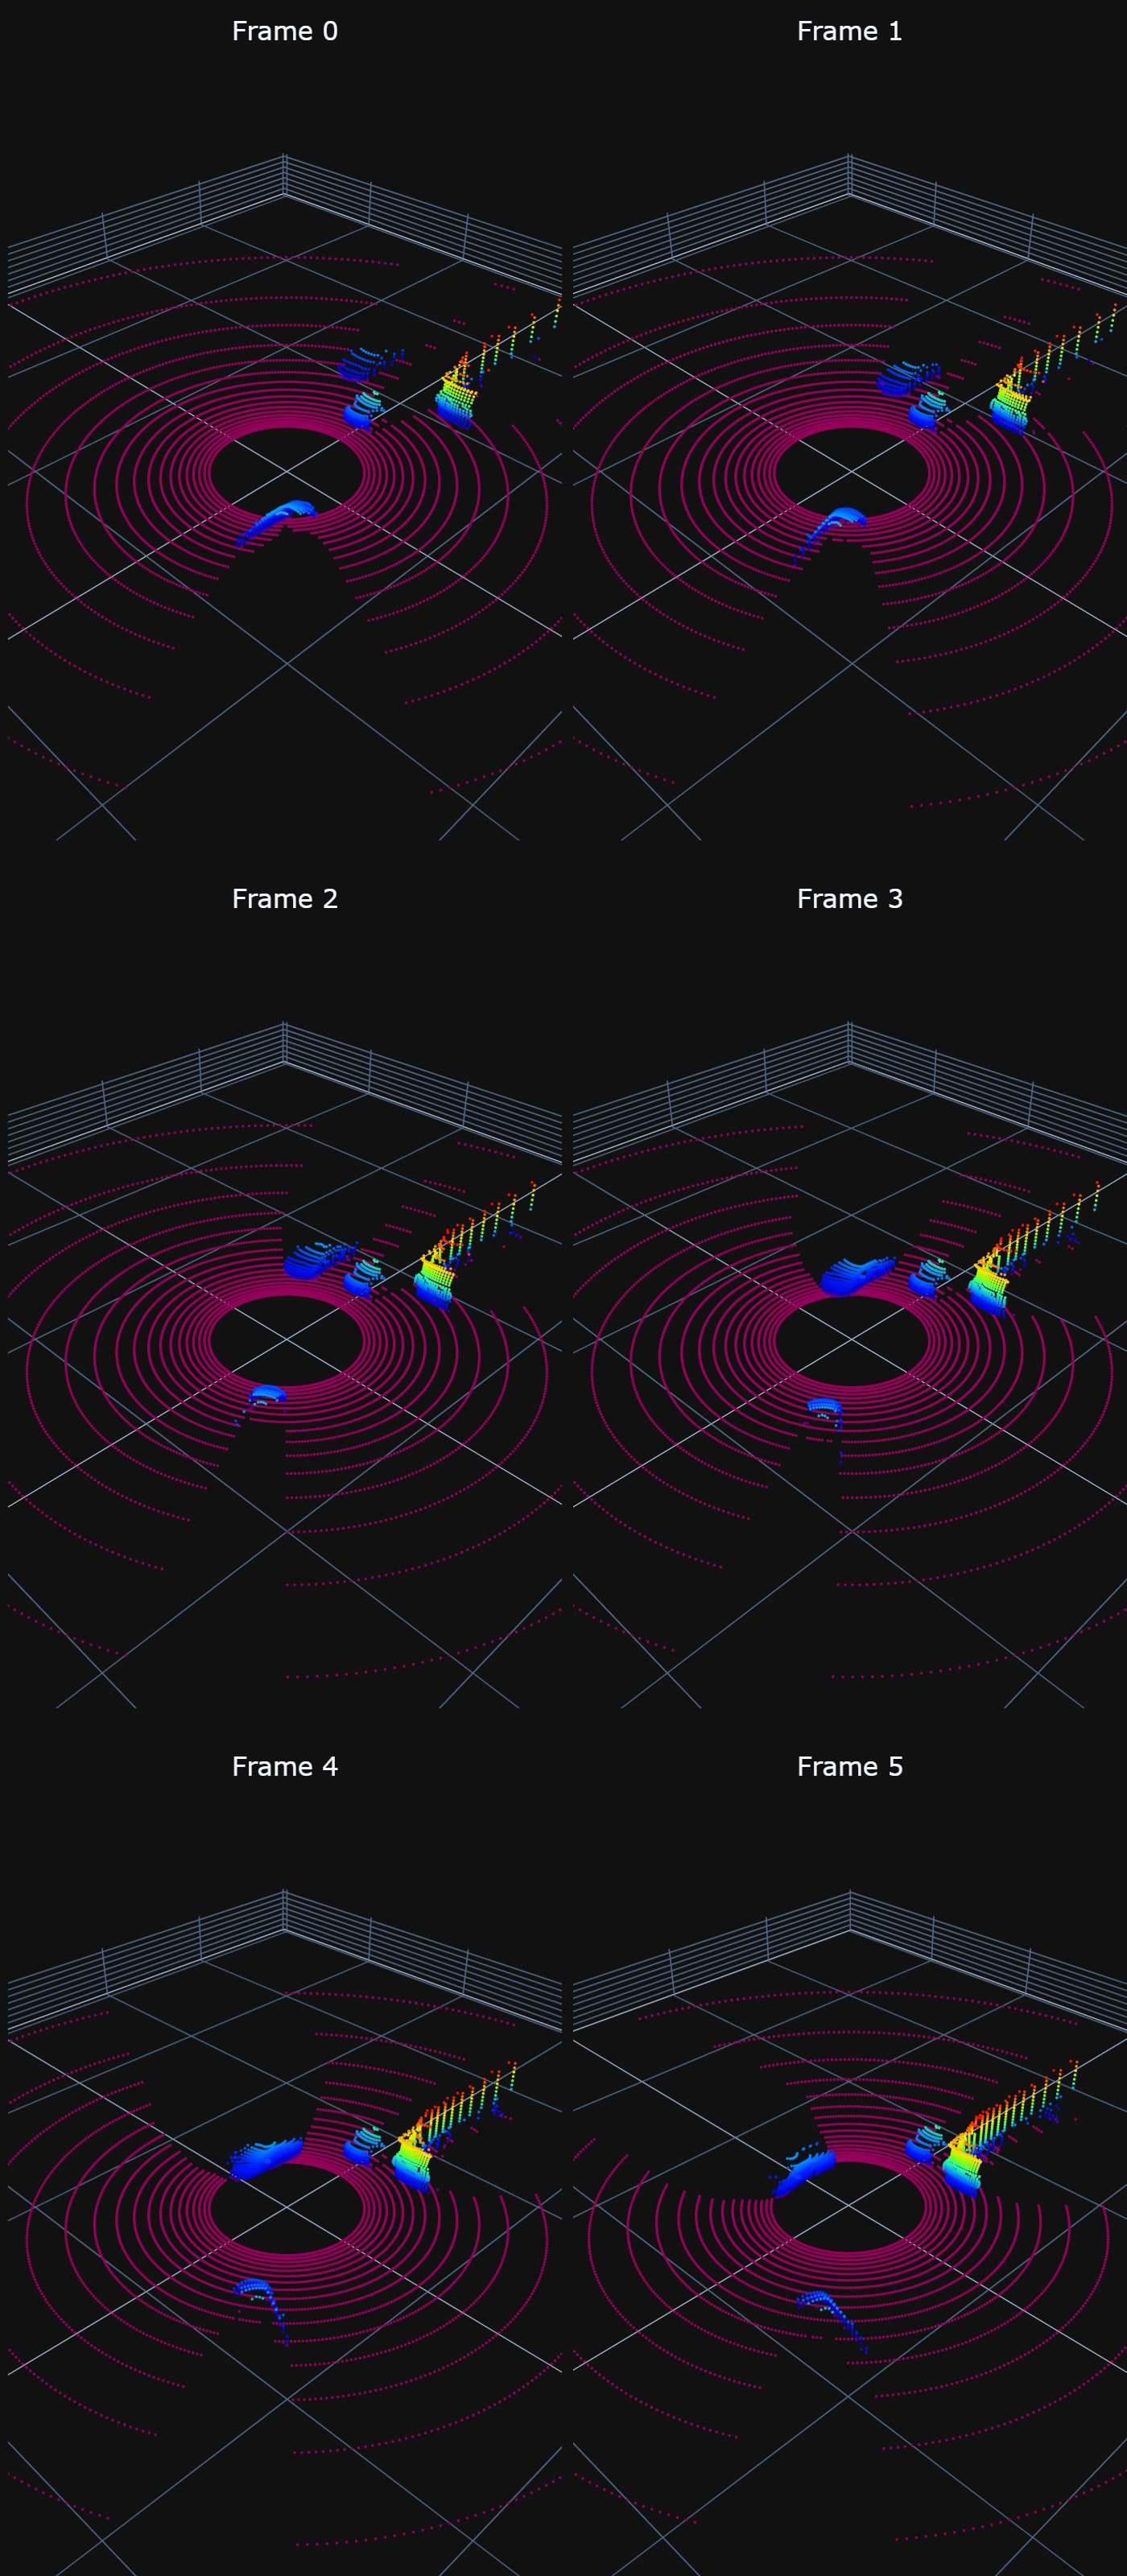

In [5]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from IPython.display import Image

fig = go.Figure()
fig = make_subplots(
    rows=3,
    cols=2,
    specs=[
        [{"type": "scatter3d"}, {"type": "scatter3d"}],
        [{"type": "scatter3d"}, {"type": "scatter3d"}],
        [{"type": "scatter3d"}, {"type": "scatter3d"}],
    ],
    subplot_titles=("Frame 0", "Frame 1", "Frame 2", "Frame 3", "Frame 4", "Frame 5"),
    horizontal_spacing=0.01,
    vertical_spacing=0.03,
)

for t_idx in range(0, len(time_seq)):
    fig.add_trace(
        go.Scatter3d(
            x=points[t_idx]["positions"][:, 0],
            y=points[t_idx]["positions"][:, 1],
            z=points[t_idx]["positions"][:, 2],
            mode="markers",
            marker=dict(
                size=1,
                color=points[t_idx]["positions"][:, 2],
                colorscale="Rainbow",
                opacity=1,
            ),
            showlegend=False,
        ),
        row=np.floor(t_idx / 2).astype(int) + 1,
        col=np.mod(t_idx, 2) + 1,
    )

    fig.update_scenes(
        aspectmode="data",
        row=np.floor(t_idx / 2).astype(int) + 1,
        col=np.mod(t_idx, 2) + 1,
    )

fig.update_layout(height=1600, template="plotly_dark", margin=dict(l=5, r=0, b=0, t=30))

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Summary and Key Takeaways

### RadarSimPy Functions Used

This notebook demonstrated the following RadarSimPy capabilities:

1. **`sim_lidar(lidar, targets, frame_time)`**: Main function for point cloud generation
   - Accepts lidar configuration dictionary
   - Processes list of target dictionaries (STL models)
   - Returns dictionary with `positions` array

2. **STL Mesh Loading**: Automatic handling of 3D models
   - Specify path in `model` parameter
   - RadarSimPy loads and triangulates meshes internally

3. **Ray Tracing Engine**: Behind-the-scenes processing
   - Launches rays at specified angles
   - Computes intersections with mesh triangles
   - Returns first hit points (lidar returns)

4. **Motion Handling**: Two approaches
   - Automatic: Use `speed` parameter with `frame_time`
   - Manual: Update `location` and `rotation` between calls

### RadarSimPy Configuration Best Practices

**Lidar Configuration:**
```python
lidar = {
    "position": [x, y, z],           # Sensor location
    "phi": np.arange(start, stop, step),     # Horizontal angles
    "theta": np.arange(start, stop, step)    # Vertical angles
}
```

**Target Configuration:**
```python
target = {
    "model": "path/to/file.stl",     # Required: 3D model file (.stl, .obj, etc.)
    "location": [x, y, z],           # Optional: position (default [0,0,0])
    "rotation": [yaw, pitch, roll],  # Optional: orientation (default [0,0,0])
    "speed": [vx, vy, vz],          # Optional: velocity for auto-motion
    "rotation_rate": [yaw_rate, pitch_rate, roll_rate]  # Optional: angular velocity
}
```

### Practical Usage Tips

1. **Angular Resolution vs. Performance:**
   - Finer angle steps → more rays → higher point density → longer computation
   - Example: 0.5° step = 4× more rays than 1° step
   - Balance resolution needs with computation time

2. **3D Model Format Support:**
   - RadarSimPy supports most common 3D formats: STL, OBJ, and others
   - Models should be closed, manifold meshes for best results
   - Units should be consistent (typically meters)
   - Models from CAD software or online repositories work well

3. **Scene Complexity:**
   - More triangles = longer ray tracing time
   - Simplify models if performance is critical
   - RadarSimPy handles occlusion automatically

4. **Motion Simulation:**
   - Use `speed` for simple linear motion
   - Use manual updates for complex trajectories
   - Update targets list between `sim_lidar()` calls

### Experiment Further

Try these modifications to explore RadarSimPy's capabilities:

1. **Adjust scanning resolution:**
   ```python
   "phi": np.arange(0, 360, 0.5),     # Higher resolution
   "theta": np.arange(70, 110, 0.5)
   ```

2. **Change sensor position:**
   ```python
   "position": [5, 0, 2.0]  # Different viewpoint
   ```

3. **Add more targets:**
   ```python
   targets.append({"model": "path/to/new_object.stl", "location": [10, 5, 0]})
   # Or use other formats: .obj, etc.
   targets.append({"model": "path/to/object.obj", "location": [15, 0, 0]})
   ```

4. **Modify motion parameters:**
   ```python
   "speed": [3, 2, 0],  # Diagonal motion
   "rotation_rate": [0, 0, 45]  # Rotating object
   ```

### Related RadarSimPy Functions

- **`sim_radar()`**: For radar simulation with same targets
- **`rcs_sbr()`**: For RCS computation using shooting-and-bouncing rays
- **Ray tracing**: Same engine powers both lidar and radar simulations

### Resources

- RadarSimPy Documentation: https://radarsimx.com
- API Reference: https://radarsimx.github.io/radarsimpy/
- GitHub Repository: https://github.com/radarsimx/radarsimpy
